# Moving Averages On Security Prices

One of the oldest single-security trading strategies is based on moving averages.  If a security price seems to be above its recent average, then it is likeliest to drop and we should short it.  If the price is below its average, we should buy it.

* _short_ is a verb in trading, but _long_ is **not** a verb.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import quandl
import pandas as pd
import numpy as np
import functools

In [7]:
@functools.lru_cache(maxsize=1600)
def fetch_quandl(my_data_items, trim_start=None, returns="pandas"):
    qdata = quandl.get(list(my_data_items), returns=returns, 
                      trim_start=trim_start,
                      api_key='Quandl API Key')
    return qdata

We will fetch prices for Sunoco equity.  This security has cashflows in the form of dividends, so we need to adjust for them.  Happily, in the case of equity prices, that is often done for us in the form of _Adjusted_ prices

In [28]:
sunoco_details = fetch_quandl(('EOD/SUN',))


In [24]:
sunoco_prices = sunoco_details['EOD/SUN - Adj_Close']

sunoco_prices.index[[0,-1]].to_series().diff().iloc[-1]

Timedelta('2013 days 00:00:00')

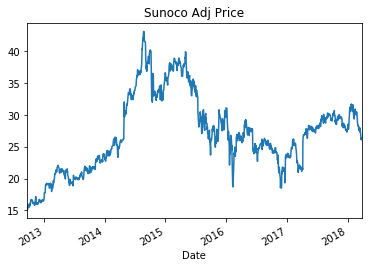

In [26]:
sunoco_prices.plot(title="Sunoco Adj Price")
None

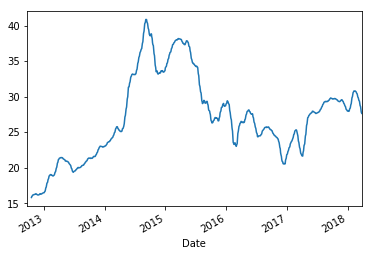

In [27]:
sunoco_prices.rolling(20).mean().plot(title="Sunoco Rolling 20 Day Average Price")
None

Now let us imagine buying one share of Sunoco at the next day's open price whenever its daily close has exceeded the 20-day average, then selling the share at the close price.  We pretend we will short when the close is below the average, covering the short at the close.

This strategy is not exactly feasible in the equity markets, but it is a way to think about identifying opportunity.

In [43]:
rolling_avg = sunoco_prices.rolling(20).mean()
available_avg = rolling_avg.notnull()
rolling_avg = rolling_avg[available_avg]
rolling_avg.head()

Date
2012-10-17    15.826912
2012-10-18    15.902966
2012-10-19    15.970093
2012-10-22    16.038541
2012-10-23    16.098393
Name: EOD/SUN - Adj_Close, dtype: float64

In [52]:

buy_ix = (sunoco_prices[available_avg] < rolling_avg).shift(1).iloc[1:]
sell_ix = (sunoco_prices[available_avg] > rolling_avg).shift(1).iloc[1:]


In [53]:
buy_ix.head()

Date
2012-10-18    False
2012-10-19    False
2012-10-22    False
2012-10-23    False
2012-10-24    False
Name: EOD/SUN - Adj_Close, dtype: object

In [54]:
sell_ix.head()

Date
2012-10-18    True
2012-10-19    True
2012-10-22    True
2012-10-23    True
2012-10-24    True
Name: EOD/SUN - Adj_Close, dtype: object

Profit opportunities from buys are just the close price minus the open price, and vice versa for the shorts

In [60]:
sunoco_open_prices = sunoco_details['EOD/SUN - Adj_Open'][available_avg]

buy_opportunity = (sunoco_prices[available_avg][1:] - sunoco_open_prices[1:])[buy_ix]
short_opportunity = -(sunoco_prices[available_avg][1:] - sunoco_open_prices[1:])[sell_ix]

In [61]:
short_opportunity.head()

Date
2012-10-18   -0.198403
2012-10-19    0.158722
2012-10-22    0.066134
2012-10-23   -0.033067
2012-10-24    0.264537
dtype: float64

The overall opportunity is then the combination of the two

In [62]:
overall = pd.concat([buy_opportunity, short_opportunity]).sort_index()
overall.head()

Date
2012-10-18   -0.198403
2012-10-19    0.158722
2012-10-22    0.066134
2012-10-23   -0.033067
2012-10-24    0.264537
dtype: float64

We can then judge whether or not there might be some reasonable chance of making money

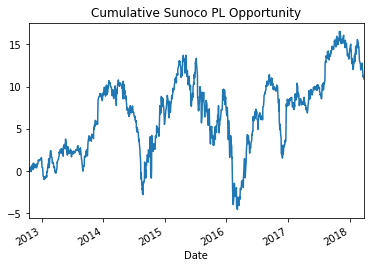

In [64]:
overall.cumsum().plot(title="Cumulative Sunoco PL Opportunity")
None

As we see, this would have looked like a foolish strategy at the beginning of 2016, and looks somewhat better in 2018 but is still clearly very risky